# Data Loading

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Set seeds
np.random.seed(42)
random.seed(42)

In [2]:
df1 = pd.read_excel('/kaggle/input/male-fertility/DIB dataset and codebook.xlsx')
df2 = pd.read_csv('/kaggle/input/text-zs-rep/text_zero_shot.csv')

In [3]:
# Selecting specific features from df1 and df2
df1_selected = df1[['OS23', 'OS17', 'OS11', 'OS7', 'OS37', 'OS21', 'OS31', 'OS12', 'OS16', 
                     'OS15', 'OS5', 'OS32', 'OS18', 'Household income', 'OS30', 'OS35', 'OS38',
                     'OS1', 'OS29', 'OS6', 'OS20', 'OS8', 'OS27', 'OS19', 'OS33', 'OS14']]  
df2_selected = df2[['ZS_Label']]  

# Combining the selected features into a new DataFrame df3
df3 = pd.concat([df1_selected, df2_selected], axis=1)

In [4]:
df3.head()

,OS23,OS17,OS11,OS7,OS37,OS21,OS31,OS12,OS16,OS15,...,OS1,OS29,OS6,OS20,OS8,OS27,OS19,OS33,OS14,ZS_Label
0,5,5,5,3,4,5,5,4,5,5,...,2,5,3,5,5,5,5,5,4,0
1,4,4,5,4,2,5,5,5,2,4,...,4,5,4,5,5,4,5,4,5,1
2,5,5,4,2,4,5,5,4,5,5,...,3,5,3,5,5,5,5,4,5,0
3,4,5,5,2,4,5,4,5,3,5,...,2,4,2,4,3,5,4,2,4,1
4,5,5,5,1,4,5,5,5,5,5,...,5,4,3,5,3,5,5,5,5,0


In [5]:
df3.columns

Index(['OS23', 'OS17', 'OS11', 'OS7', 'OS37', 'OS21', 'OS31', 'OS12', 'OS16',
       'OS15', 'OS5', 'OS32', 'OS18', 'Household income', 'OS30', 'OS35',
       'OS38', 'OS1', 'OS29', 'OS6', 'OS20', 'OS8', 'OS27', 'OS19', 'OS33',
       'OS14', 'ZS_Label'],
      dtype='object')

In [6]:
df3['ZS_Label'].value_counts()

ZS_Label
1    167
0    142
Name: count, dtype: int64

# Data Splitting

In [7]:
X = df3.drop(['ZS_Label'], axis=1)  # Features
y = df3['ZS_Label']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42) 

**Data Normalization**

In [8]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrame for easier handling
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Model Selection

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Hyperparameter Optimization - Randomized Search CV

In [10]:
# Define model hyperparameter spaces
param_distributions = {
    'DecisionTreeClassifier': {
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    'LGBMClassifier': {
        'num_leaves': [31, 62, 127],
        'learning_rate': [0.01, 0.1, 0.5],
        'n_estimators': [100, 200, 300]
    },
    'XGBClassifier': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 6, 9]
    },
    
    'LogisticRegression': {
        'C': np.logspace(-4, 4, 20),
        'solver': ['liblinear', 'lbfgs', 'saga'],
        'max_iter': [100, 200, 500, 1000], 
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

# Instantiate models
models = {
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'LGBMClassifier': LGBMClassifier(verbose=-1),
    'XGBClassifier': XGBClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC(),
    'KNeighborsClassifier': KNeighborsClassifier()
}

best_params = {}

for model_name, model in models.items():
    print(f"Running RandomizedSearchCV for {model_name}")
    clf = RandomizedSearchCV(model, param_distributions[model_name], n_iter=10, cv=5, verbose=1, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    best_params[model_name] = clf.best_params_
    print(f"Best parameters for {model_name}: {clf.best_params_}")

Running RandomizedSearchCV for DecisionTreeClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for DecisionTreeClassifier: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}
Running RandomizedSearchCV for RandomForestClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for RandomForestClassifier: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
Running RandomizedSearchCV for AdaBoostClassifier
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for AdaBoostClassifier: {'n_estimators': 50, 'learning_rate': 1.0}
Running RandomizedSearchCV for LGBMClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for LGBMClassifier: {'num_leaves': 62, 'n_estimators': 200, 'learning_rate': 0.1}
Running RandomizedSearchCV for XGBClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for XGBClassifier: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.01}
Running RandomizedSearchCV for LogisticRegression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for LogisticRegression: {'solver': 'saga', 'max_iter': 100, 'C': 0.08858667904100824}
Running RandomizedSearchCV for SVC
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for SVC: {'kernel': 'rbf', 'C': 10}
Running RandomizedSearchCV for KNeighborsClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for KNeighborsClassifier: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}


# Model Training and Evaluation

Classification Report for DecisionTreeClassifier:
               precision    recall  f1-score   support

           0     0.9310    0.9643    0.9474        28
           1     0.9697    0.9412    0.9552        34

    accuracy                         0.9516        62
   macro avg     0.9504    0.9527    0.9513        62
weighted avg     0.9522    0.9516    0.9517        62

ROC-AUC Score for DecisionTreeClassifier: 0.9517
__________________________

Classification Report for RandomForestClassifier:
               precision    recall  f1-score   support

           0     0.8966    0.9286    0.9123        28
           1     0.9394    0.9118    0.9254        34

    accuracy                         0.9194        62
   macro avg     0.9180    0.9202    0.9188        62
weighted avg     0.9200    0.9194    0.9195        62

ROC-AUC Score for RandomForestClassifier: 0.9842
__________________________

Classification Report for AdaBoostClassifier:
               precision    recall  f1-score

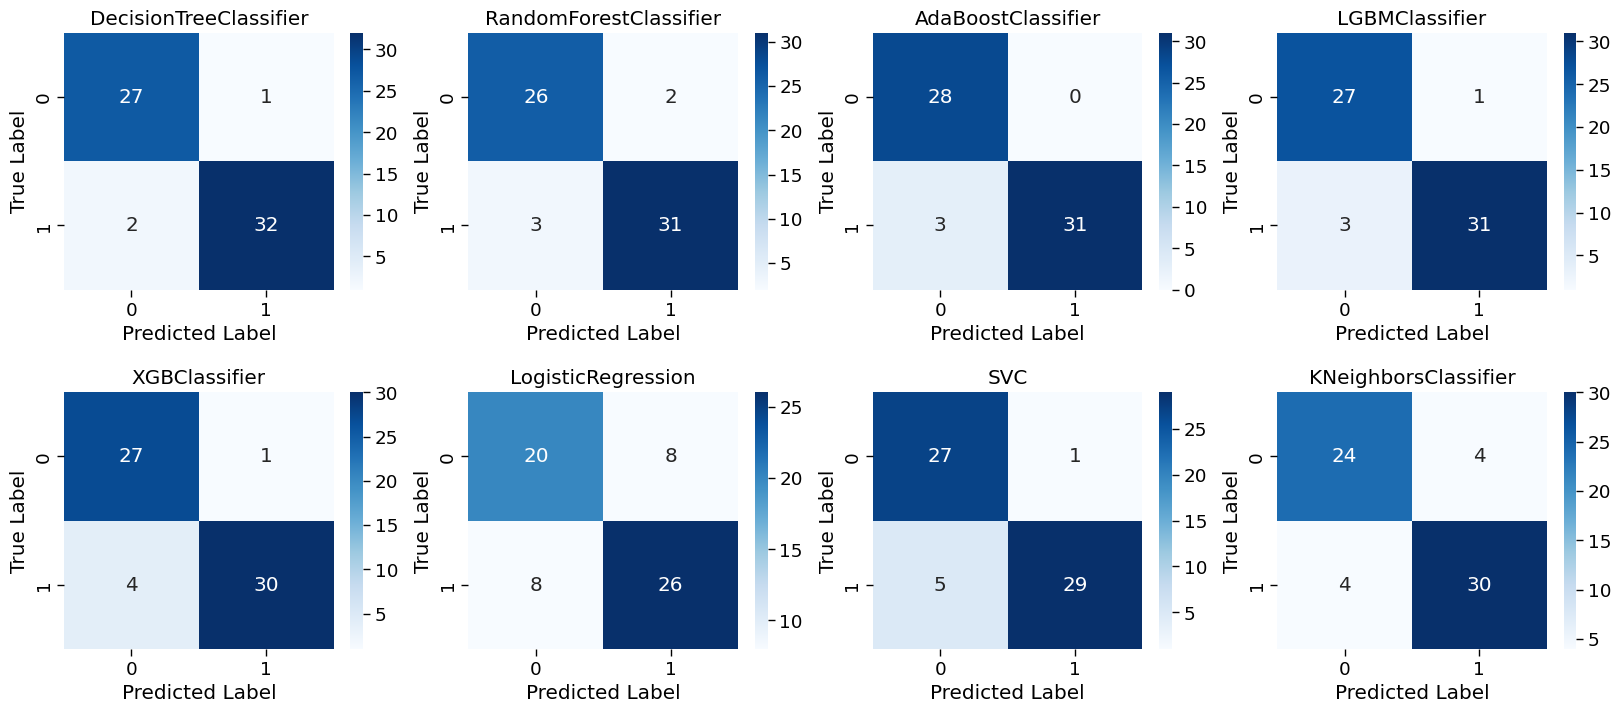

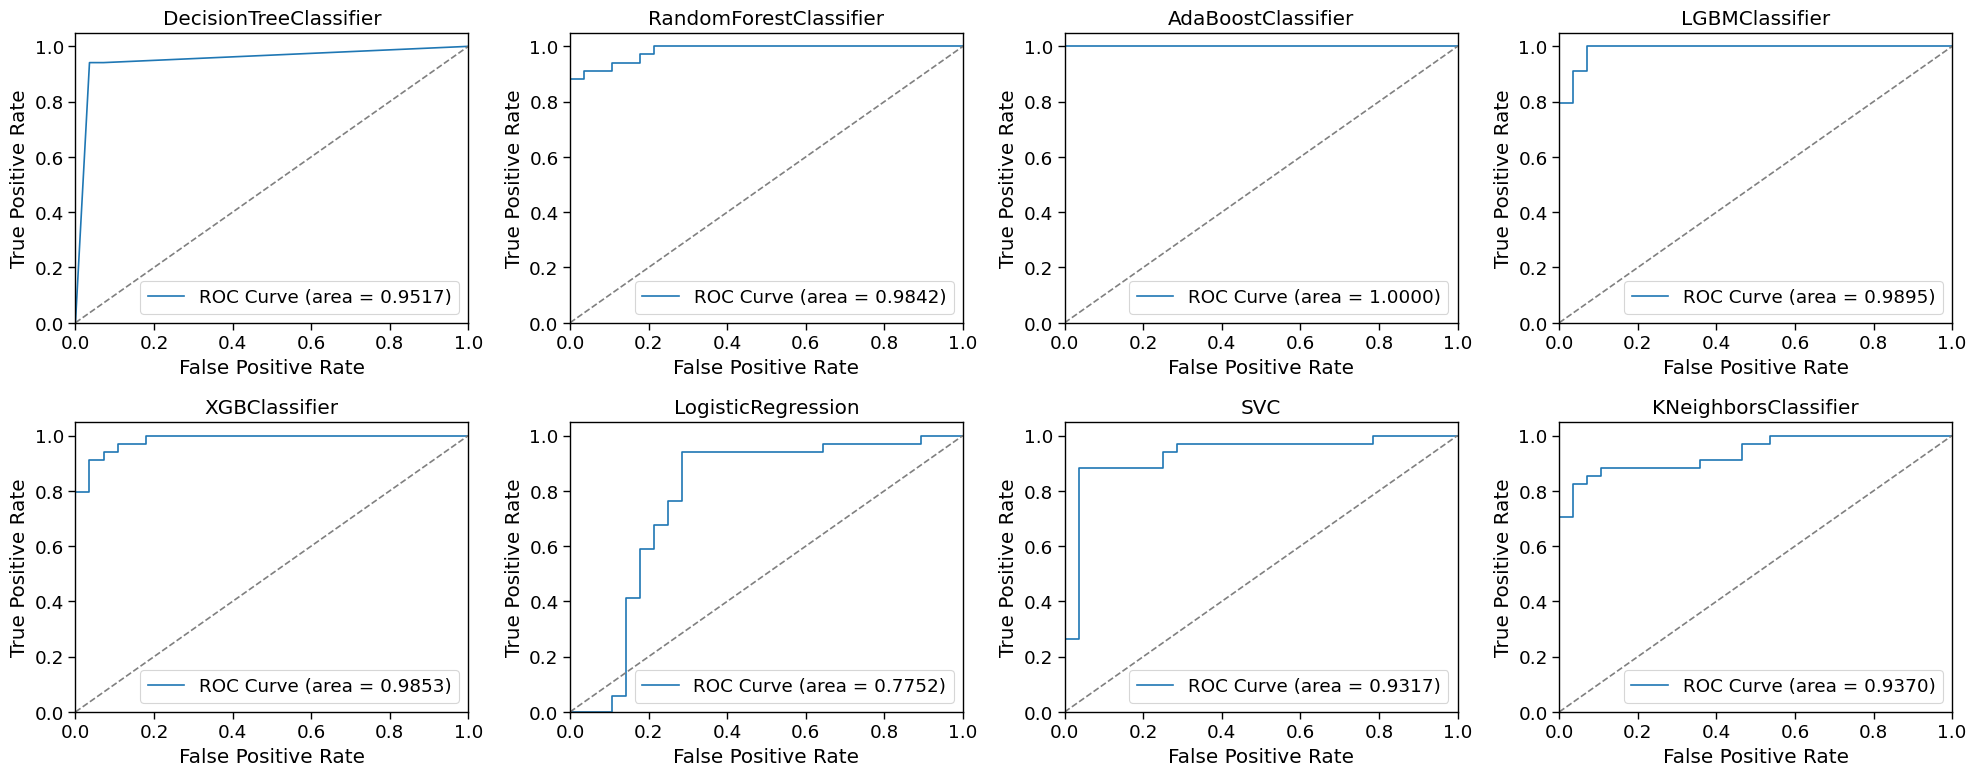

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Adjust plot settings for better readability
sns.set_context("paper", font_scale=1.5)

# Create subplots for confusion matrices and ROC curves
fig_conf_matrix, axes_conf_matrix = plt.subplots(2, 4, figsize=(20, 8))  # 4 per row, 2 rows
plt.subplots_adjust(hspace=0.4)  # Adjust the height space between rows
fig_roc_curve, axes_roc_curve = plt.subplots(2, 4, figsize=(20, 8))  # 4 per row, 2 rows

# Flatten the axes for easier iteration
axes_conf_matrix = axes_conf_matrix.flatten()
axes_roc_curve = axes_roc_curve.flatten()

for idx, (model_name, model) in enumerate(models.items()):
    # Initialize the model with the best parameters
    optimized_model = model.set_params(**best_params[model_name])

    # Train the model
    optimized_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = optimized_model.predict(X_test)


    # For models that support predict_proba, use it to calculate ROC-AUC
    if hasattr(optimized_model, "predict_proba"):
        y_proba = optimized_model.predict_proba(X_test)[:, 1]
    elif hasattr(optimized_model, "decision_function"):
        y_proba = optimized_model.decision_function(X_test)
    else:
        y_proba = y_pred  # If neither method is available, fall back to predictions
    y_pred_binary = y_pred

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_binary)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, ax=axes_conf_matrix[idx])
    axes_conf_matrix[idx].set_title(f'{model_name}')
    axes_conf_matrix[idx].set_xlabel('Predicted Label')
    axes_conf_matrix[idx].set_ylabel('True Label')

    # Classification report
    class_report = classification_report(y_test, y_pred_binary, digits = 4)
    print(f"Classification Report for {model_name}:\n", class_report)
    
    # Calculate and print the ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC Score for {model_name}: {roc_auc:.4f}")
    print("__________________________\n")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    axes_roc_curve[idx].plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.4f})')
    axes_roc_curve[idx].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axes_roc_curve[idx].set_xlim([0.0, 1.0])
    axes_roc_curve[idx].set_ylim([0.0, 1.05])
    axes_roc_curve[idx].set_xlabel('False Positive Rate')
    axes_roc_curve[idx].set_ylabel('True Positive Rate')
    axes_roc_curve[idx].set_title(f'{model_name}')
    axes_roc_curve[idx].legend(loc='lower right')

# Adjust layout and save the confusion matrix figure as a PDF
plt.tight_layout()
fig_conf_matrix.savefig('confusion_matrices_zs.pdf', format='pdf')
fig_conf_matrix.savefig('confusion_matrices_zs.png', format='png')

# Adjust layout and save the ROC curve figure as a PDF
plt.tight_layout()
fig_roc_curve.savefig('roc_curves_zs.pdf', format='pdf')
fig_roc_curve.savefig('roc_curves_zs.png', format='png')

# Display the figures
plt.show()
